# Stacking Features and Targets

This notebook is focused on joining all the features and targets together and engineering KGML features.

In [22]:
import os
import sys
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

sys.path.append(os.path.abspath('../notebooks'))

from src.PM_eq import penman_monteith

In [8]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

- MODIS and ERA data are loaded from multidimensional arrays representing 30 day time series.
- Fluxes are loaded from the FLUXNET and AmeriFlux dump and filtered by QC keeping only the measurements with QC 75% or higher.

In [10]:
mod = np.load('../data_v02/MOD_features_all.npy', allow_pickle=True)
mod_idxs = set(np.load('../data_v02/MOD_target_idx_all.npy', allow_pickle=True))
era5 = np.load('../data_v02/ERA5_features.npy', allow_pickle=True)
era5_idxs = era5[:,0,-1].astype(int)
era5 = era5[:,:,:-1] # drop last (idx)

fluxes = pd.read_csv('../data_v02/target_fluxes_MidWest_LE.csv')
fluxes = fluxes[fluxes['LE_F_MDS_QC']>=0.75]
keep_idxs = [idx for idx in fluxes.index.tolist() if (idx in era5_idxs) and (idx in mod_idxs)]
fluxes = fluxes.loc[keep_idxs,:]
fluxes['TIMESTAMP'] = pd.to_datetime(fluxes.TIMESTAMP, format='%Y%m%d')
targets = fluxes.LE_F_MDS.values

fluxes

,TIMESTAMP,LE_F_MDS,LE_F_MDS_QC,NETRAD,G_F_MDS,TA_F,VPD_F,WS_F,PA_F,site,H_F_MDS,lat,lon,IGBP
0,2003-05-24,19.2224,1.0000,236.108854,-1.567770,11.213,10.345,1.841,98.421,FLX_US-Wi1,138.470000,46.7305,-91.2329,DBF
1,2003-05-25,24.2024,1.0000,227.120214,-1.126670,12.308,10.551,1.835,98.471,FLX_US-Wi1,112.405000,46.7305,-91.2329,DBF
2,2003-05-26,19.4017,0.9375,249.112486,0.019932,14.778,12.203,1.660,98.656,FLX_US-Wi1,108.937000,46.7305,-91.2329,DBF
3,2003-05-27,23.7468,1.0000,244.104535,1.914990,18.154,15.802,1.532,98.265,FLX_US-Wi1,112.939000,46.7305,-91.2329,DBF
4,2003-05-28,42.2603,0.9375,246.821474,0.114018,14.890,6.921,2.285,97.722,FLX_US-Wi1,85.043500,46.7305,-91.2329,DBF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155271,2003-09-11,55.7628,1.0000,126.808894,7.353920,23.534,10.864,2.743,96.827,AMF_US-Wi3,15.796000,46.6347,-91.0987,DBF
155272,2003-09-13,31.6040,1.0000,65.703064,-8.120460,15.390,2.544,1.353,96.572,AMF_US-Wi3,-8.821360,46.6347,-91.0987,DBF
155273,2003-09-14,54.2463,1.0000,92.268000,-8.471200,13.966,4.375,1.341,96.912,AMF_US-Wi3,-10.596500,46.6347,-91.0987,DBF
155274,2003-09-15,44.2428,1.0000,99.622415,-3.575530,12.401,3.585,1.304,96.968,AMF_US-Wi3,-0.490375,46.6347,-91.0987,DBF


- Computing KGML features and  joining ERA5 and MODIS

In [15]:
era5_idxs = pd.Series(list(era5_idxs))
era5_idxs.index = np.arange(len(era5_idxs))
valid_feature_indices = era5_idxs[era5_idxs.isin(fluxes.index)].index.values
era5_features = era5[valid_feature_indices]

mod_idxs = pd.Series(list(mod_idxs))
mod_idxs.index = np.arange(len(mod_idxs))
valid_feature_indices = mod_idxs[mod_idxs.isin(fluxes.index)].index.values
mod_features = mod[valid_feature_indices]
#mod_features = mod_features[:,:,:-1]#Dropping Coarse_Resolution_Internal_CM

Red, Blue, Green, NIR = mod_features[:,:,4], mod_features[:,:,6], mod_features[:,:,7], mod_features[:,:,5]
Red, Blue, Green, NIR = Red*1e-4, Blue*1e-4, Green*1e-4, NIR*1e-4

Red, Blue, Green, NIR = mod_features[:,:,4], mod_features[:,:,6], mod_features[:,:,7], mod_features[:,:,5]
Red, Blue, Green, NIR = Red*1e-4, Blue*1e-4, Green*1e-4, NIR*1e-4
NDVI = (NIR - Red) / (NIR + Red)
EVI = (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
GNDVI = (NIR - Green) / (NIR + Green)
SAVI = (NIR - Red) / (NIR + Red) / (NIR + Red + 0.5)*1.5
ARVI = (NIR - 2*Red + Blue) / (NIR + 2*Red + Blue)

pm_era = penman_monteith(era5_features, fluxes.index, fluxes, mode='era5') 

features = np.concatenate([era5_features, mod_features, pm_era[:, :, np.newaxis],
                           NDVI[:,:, np.newaxis], EVI[:,:, np.newaxis], GNDVI[:,:, np.newaxis],
                           SAVI[:,:, np.newaxis], ARVI[:,:, np.newaxis]], axis=2)

era_names = list(np.loadtxt('../data_v02/ERA5_features_names.txt', dtype=str))[:-1]
mod_names = [
          'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth',
         'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04',
         'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 'Clouds'
]
df = pd.DataFrame(data=features[:,-1,:], columns=era_names + mod_names + ['LE_PM'] + ['NDVI', 'EVI', "GNDVI", 'SAVI', 'ARVI']) 
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,sur_refl_b05,sur_refl_b06,sur_refl_b07,Clouds,LE_PM,NDVI,EVI,GNDVI,SAVI,ARVI
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,2830.0,2571.0,1417.0,0.0,1081.726205,0.535801,0.113596,0.575027,1.018504,0.313555
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,2445.0,1658.0,824.0,0.0,1258.958567,0.629603,0.133667,0.573352,1.211241,0.426039
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,3134.0,2707.0,1477.0,0.0,1461.640686,0.583694,0.135820,0.583694,1.062807,0.368766
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,2694.0,1866.0,894.0,0.0,1630.192334,0.674196,0.148461,0.615588,1.276564,0.481058
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,3752.0,2555.0,1281.0,1.0,1128.381330,0.608979,0.190840,0.557113,0.999091,0.423077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,3195.0,1710.0,756.0,1.0,901.577173,0.424357,0.217824,0.355524,0.653125,0.295513
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,8548.0,6065.0,3633.0,1.0,600.613445,0.012226,0.024327,0.018917,0.007728,-0.007597
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,5472.0,3626.0,2687.0,1.0,551.771251,0.082861,0.105994,0.072437,0.079695,0.044256
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,3804.0,2267.0,1467.0,1.0,646.839456,0.487710,0.195259,0.454788,0.722462,0.311123


- Computing rolling means and sums from the time series and joining them as well

In [16]:
samples, timesteps, variables = features.shape

f = features.transpose(2, 0, 1) # (variables, samples, timesteps)

results = {}
for idx, col in enumerate(era_names+['LE_PM']):
    x = f[idx]  # (samples, timesteps)
    if col in ['surface_net_solar_radiation_sum','total_evaporation_sum','total_precipitation_sum']:
        rol_30 = np.apply_along_axis(lambda m: np.sum(m[-30:]), 1, x)
        rol_7 = np.apply_along_axis(lambda m: np.sum(m[-7:]), 1, x)
    else:
        rol_30 = np.apply_along_axis(lambda m: np.mean(m[-30:]), 1, x)
        rol_7 = np.apply_along_axis(lambda m: np.mean(m[-7:]), 1, x)
    results[col+'_rol_30'] = rol_30
    results[col+'_rol_7'] = rol_7
    results[col+'_min'] = x.min(axis=1)
    results[col+'_max'] = x.max(axis=1)
    results[col+'_std'] = x.std(axis=1)
df = pd.DataFrame({**dict(zip(df.columns, df.values.T)), **results})
df['doy'] = fluxes['TIMESTAMP'].reset_index(drop=True).dt.dayofyear
df['year'] = fluxes['TIMESTAMP'].reset_index(drop=True).dt.year
df['lat'] = fluxes.lat.values
df['lon'] = fluxes.lon.values
df['IGBP'] = fluxes.IGBP.values
df['IGBP'] = df.IGBP.astype('category')
df['LE'] = fluxes.LE_F_MDS.values
df['site'] = fluxes.site.values

In [17]:
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,LE_PM_min,LE_PM_max,LE_PM_std,doy,year,lat,lon,IGBP,LE,site
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,-8091.0,14466.0,8784.635791,144,2003,46.7305,-91.2329,DBF,19.2224,FLX_US-Wi1
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,-8091.0,14466.0,8777.804913,145,2003,46.7305,-91.2329,DBF,24.2024,FLX_US-Wi1
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,-8091.0,14466.0,8787.811435,146,2003,46.7305,-91.2329,DBF,19.4017,FLX_US-Wi1
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,-8091.0,14466.0,8783.096294,147,2003,46.7305,-91.2329,DBF,23.7468,FLX_US-Wi1
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,-8091.0,14466.0,8793.252106,148,2003,46.7305,-91.2329,DBF,42.2603,FLX_US-Wi1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,-16360.0,10298.0,9104.513256,254,2003,46.6347,-91.0987,DBF,55.7628,AMF_US-Wi3
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,-16360.0,10298.0,9111.153304,256,2003,46.6347,-91.0987,DBF,31.6040,AMF_US-Wi3
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,-16360.0,10298.0,9106.642548,257,2003,46.6347,-91.0987,DBF,54.2463,AMF_US-Wi3
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,-16360.0,10348.0,9121.591650,258,2003,46.6347,-91.0987,DBF,44.2428,AMF_US-Wi3


In [18]:
df.to_csv('../data_v02/dataset_final.csv', index=None)

In [19]:
colors = ['brown', 'darkcyan']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

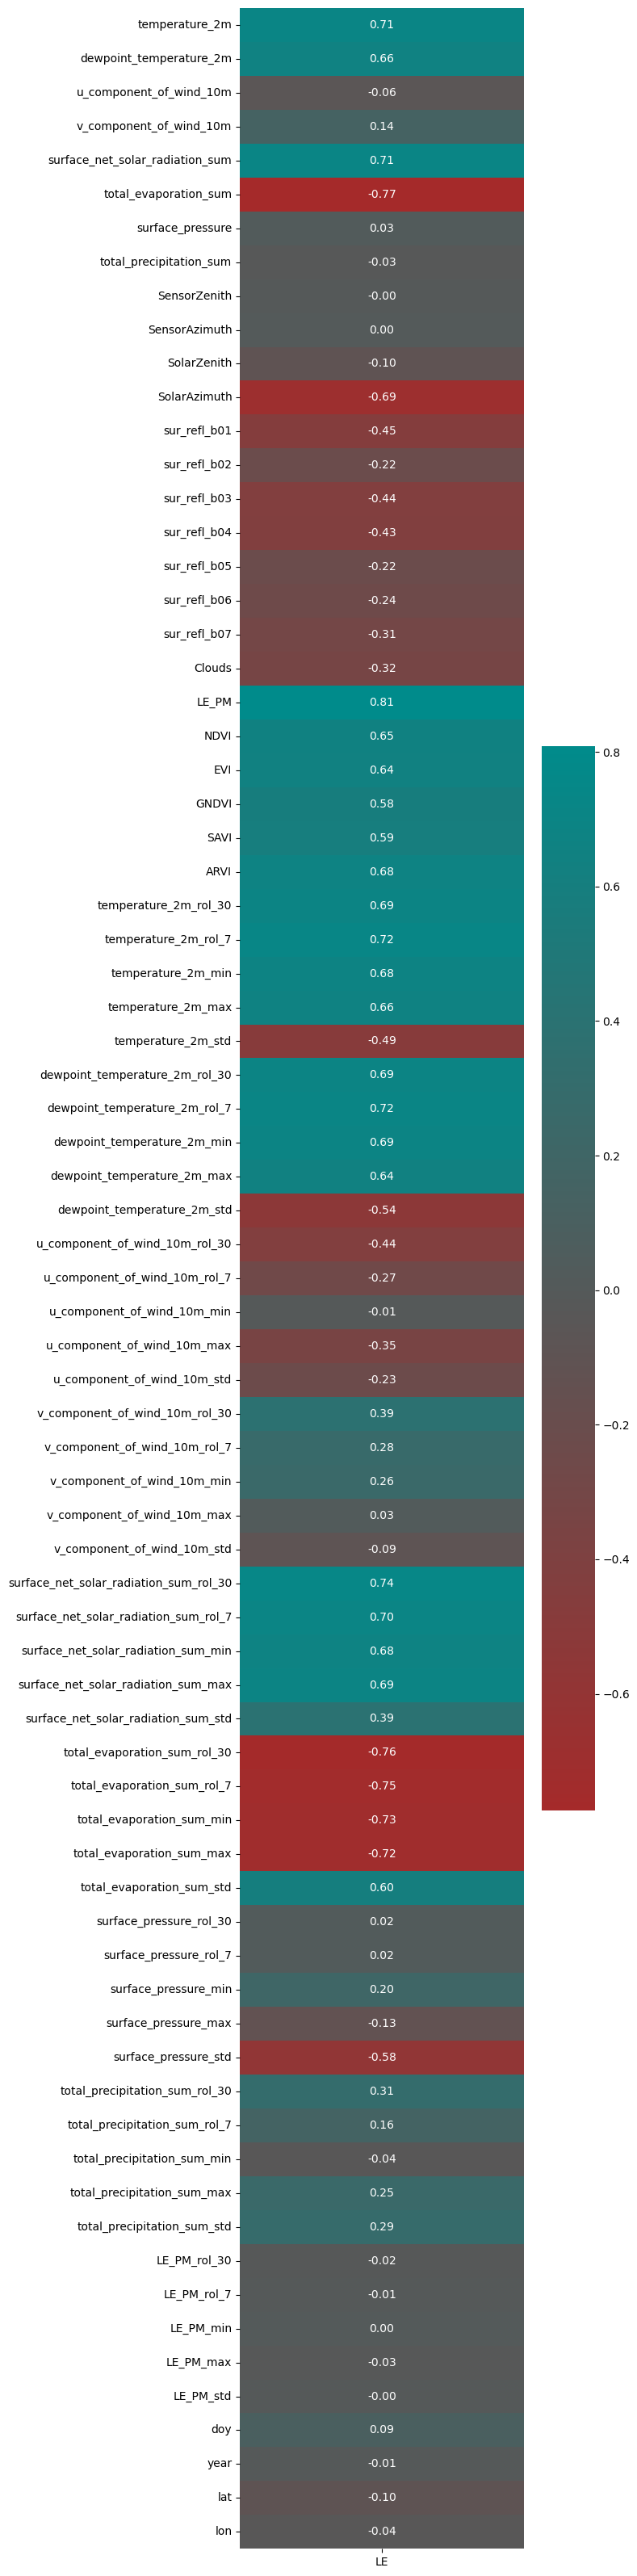

In [23]:
correlation_matrix = df.drop(['IGBP','site'], axis=1).corr()[["LE"]].iloc[:-1]

plt.figure(figsize=(8, 32))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, cbar=True, fmt=".2f")
plt.tight_layout()
plt.show()